# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак
- Price — цена (евро)

<h1>Содержание<span class="tocSkip"></span></h1>


[1.Подготовка данных](#section_id)

[2.Обучение моделей](#section_i)

[2.1 LinearRegression](#sectio)

[2.2 RandomForestRegressor](#secti)

[2.3 CatBoostRegressor](#sect)

[2.4 LGBMRegressor](#sec)

[3.Анализ моделей](#section)


## Подготовка данных
<a id='section_id'></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from scipy.stats import mode

from sklearn.preprocessing import StandardScaler,OrdinalEncoder
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

from catboost import CatBoostRegressor as cat
from lightgbm import LGBMRegressor 

In [2]:
df = pd.read_csv('/datasets/autos.csv')
df

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
for column in df.columns:
    missing_values = np.mean(df[column].isna())
    print('{} - {}%'.format(column, round(missing_values*100)))

DateCrawled - 0%
Price - 0%
VehicleType - 11%
RegistrationYear - 0%
Gearbox - 6%
Power - 0%
Model - 6%
Kilometer - 0%
RegistrationMonth - 0%
FuelType - 9%
Brand - 0%
NotRepaired - 20%
DateCreated - 0%
NumberOfPictures - 0%
PostalCode - 0%
LastSeen - 0%


Имеются пропуски в столбцах:  
    VehicleType - тип автомобильного кузова  
    Gearbox -  тип коробки передач  
    Model - модель автомобиля  
    FuelType - тип топлива  
    NotRepaired - была машина в ремонте или нет  
    
Можно заменить данными для других автомобилей со схожими характеристиками, пропуски в NotRepaired заменим на 'no'

In [5]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Выбросы RegistrationYear,минимум и максимум не соответсвуют действительности.
Выбросы Power,максимум не соответсвует действительности, 0 лошадиных сил может быть в прицепе.
Столбец NumberOfPictures принимает исключительно нулевые значения,его можно удалить

In [6]:
df['NumberOfPictures'].unique()

array([0])

In [7]:
del df['NumberOfPictures']

In [8]:
df.loc[df.duplicated(keep=False)].sort_values('PostalCode')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,36391,2016-03-18 18:46:15
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,36391,2016-03-18 18:46:15
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,66589,2016-03-28 08:46:21
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,66589,2016-03-28 08:46:21
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,75196,2016-04-07 09:44:54
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,75196,2016-04-07 09:44:54
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,89518,2016-03-09 09:46:57
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,89518,2016-03-09 09:46:57


Дубликатов немного,удалим их

In [9]:
df = df.drop_duplicates()

In [10]:
df['Brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

In [11]:
sorted(df['Model'].unique().astype('str'))



['100',
 '145',
 '147',
 '156',
 '159',
 '1_reihe',
 '1er',
 '200',
 '2_reihe',
 '300c',
 '3_reihe',
 '3er',
 '4_reihe',
 '500',
 '5_reihe',
 '5er',
 '601',
 '6_reihe',
 '6er',
 '7er',
 '80',
 '850',
 '90',
 '900',
 '9000',
 '911',
 'a1',
 'a2',
 'a3',
 'a4',
 'a5',
 'a6',
 'a8',
 'a_klasse',
 'accord',
 'agila',
 'alhambra',
 'almera',
 'altea',
 'amarok',
 'antara',
 'arosa',
 'astra',
 'auris',
 'avensis',
 'aveo',
 'aygo',
 'b_klasse',
 'b_max',
 'beetle',
 'berlingo',
 'bora',
 'boxster',
 'bravo',
 'c1',
 'c2',
 'c3',
 'c4',
 'c5',
 'c_klasse',
 'c_max',
 'c_reihe',
 'caddy',
 'calibra',
 'captiva',
 'carisma',
 'carnival',
 'cayenne',
 'cc',
 'ceed',
 'charade',
 'cherokee',
 'citigo',
 'civic',
 'cl',
 'clio',
 'clk',
 'clubman',
 'colt',
 'combo',
 'cooper',
 'cordoba',
 'corolla',
 'corsa',
 'cr_reihe',
 'croma',
 'crossfire',
 'cuore',
 'cx_reihe',
 'defender',
 'delta',
 'discovery',
 'doblo',
 'ducato',
 'duster',
 'e_klasse',
 'elefantino',
 'eos',
 'escort',
 'espace',
 

In [ ]:
df['Model'] = df.loc[:,'Model'].replace('rangerover', 'range_rover')

In [13]:
df[df['Model']=='rangerover']

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen


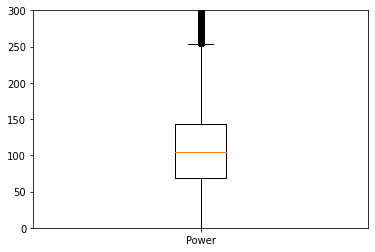

In [14]:
plt.boxplot(df.Power.dropna() , labels = ['Power'])
plt.ylim([0,300])
plt.show()


Мощность свыше 250 является выбросами

In [15]:
df[df['Price']==0]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,19348,2016-03-25 16:47:58
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26 00:00:00,56412,2016-03-27 17:43:34
111,2016-03-19 18:40:12,0,NaN,2017,manual,0,golf,5000,12,petrol,volkswagen,NaN,2016-03-19 00:00:00,21698,2016-04-01 08:47:05
115,2016-03-20 18:53:27,0,small,1999,NaN,0,NaN,5000,0,petrol,volkswagen,NaN,2016-03-20 00:00:00,37520,2016-04-07 02:45:22
152,2016-03-11 18:55:53,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,2016-03-11 00:00:00,27432,2016-03-12 23:47:10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354205,2016-03-09 15:56:30,0,NaN,2000,manual,65,corsa,150000,0,NaN,opel,yes,2016-03-09 00:00:00,23758,2016-03-30 11:16:08
354238,2016-03-20 14:55:07,0,small,2002,manual,60,fiesta,150000,3,petrol,ford,NaN,2016-03-20 00:00:00,33659,2016-04-06 18:45:23
354248,2016-03-24 13:48:05,0,small,1999,manual,53,swift,150000,3,petrol,suzuki,NaN,2016-03-24 00:00:00,42329,2016-04-07 05:17:24
354277,2016-03-10 22:55:50,0,small,1999,manual,37,arosa,150000,7,petrol,seat,yes,2016-03-10 00:00:00,22559,2016-03-12 23:46:32


In [16]:
df = df[(df['RegistrationYear'] < 2017)&(df['RegistrationYear'] > 1900)&(df['Power'] < 250)&(df['Price'] > 0)] #Удалим выбросы

Возможно выбросы появились из-за человеческого фактора,например,цену или мощность вносили в год

In [19]:
df['Model']  = df.groupby(['Brand','RegistrationYear'])['Model'].transform(
lambda x: x.fillna((x.mode()[0] if x.count() != 0 else'unknow')))

In [20]:
df.info() # из-за ошибки перепроверяла сохранение,ошибку исправить не смогла.Так и не поняла,куда вставлять .loc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 321978 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        321978 non-null  object
 1   Price              321978 non-null  int64 
 2   VehicleType        302244 non-null  object
 3   RegistrationYear   321978 non-null  int64 
 4   Gearbox            306472 non-null  object
 5   Power              321978 non-null  int64 
 6   Model              321978 non-null  object
 7   Kilometer          321978 non-null  int64 
 8   RegistrationMonth  321978 non-null  int64 
 9   FuelType           298162 non-null  object
 10  Brand              321978 non-null  object
 11  NotRepaired        263045 non-null  object
 12  DateCreated        321978 non-null  object
 13  PostalCode         321978 non-null  int64 
 14  LastSeen           321978 non-null  object
dtypes: int64(6), object(9)
memory usage: 39.3+ MB


In [21]:
df['VehicleType'] = df.groupby(['Brand','Power'])['VehicleType'].transform(
lambda x: x.fillna((x.mode()[0] if x.count() != 0 else'unknow')))

In [22]:
df['Gearbox'] = df.groupby(['Brand','Model','Power','RegistrationYear'])['Gearbox'].transform(
lambda x: x.fillna((x.mode()[0] if x.count() != 0 else'unknow')))

In [23]:
df['FuelType'] = df.groupby(['Brand','Model','Power'])['FuelType'].transform(
lambda x: x.fillna((x.mode()[0] if x.count() != 0 else'unknow')))

In [24]:
df['NotRepaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

In [25]:
df['NotRepaired'] = df.loc[:,'NotRepaired'].fillna('no')

In [26]:
df.info() # пропуски все заполнены

<class 'pandas.core.frame.DataFrame'>
Int64Index: 321978 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        321978 non-null  object
 1   Price              321978 non-null  int64 
 2   VehicleType        321978 non-null  object
 3   RegistrationYear   321978 non-null  int64 
 4   Gearbox            321978 non-null  object
 5   Power              321978 non-null  int64 
 6   Model              321978 non-null  object
 7   Kilometer          321978 non-null  int64 
 8   RegistrationMonth  321978 non-null  int64 
 9   FuelType           321978 non-null  object
 10  Brand              321978 non-null  object
 11  NotRepaired        321978 non-null  object
 12  DateCreated        321978 non-null  object
 13  PostalCode         321978 non-null  int64 
 14  LastSeen           321978 non-null  object
dtypes: int64(6), object(9)
memory usage: 39.3+ MB


In [27]:
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'])# перевела в дату,чтобы разбить по столбцам на годы и месяца, 
df['DateCreated'] = pd.to_datetime(df['DateCreated']) #на дни и часы не разбивала,не хотела перегружать компьютер
df['LastSeen'] = pd.to_datetime(df['LastSeen'])

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 321978 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        321978 non-null  datetime64[ns]
 1   Price              321978 non-null  int64         
 2   VehicleType        321978 non-null  object        
 3   RegistrationYear   321978 non-null  int64         
 4   Gearbox            321978 non-null  object        
 5   Power              321978 non-null  int64         
 6   Model              321978 non-null  object        
 7   Kilometer          321978 non-null  int64         
 8   RegistrationMonth  321978 non-null  int64         
 9   FuelType           321978 non-null  object        
 10  Brand              321978 non-null  object        
 11  NotRepaired        321978 non-null  object        
 12  DateCreated        321978 non-null  datetime64[ns]
 13  PostalCode         321978 non-null  int64   

In [29]:
df['DateCreated_y'] = df['DateCreated'].dt.year
df['DateCreated_m'] = df['DateCreated'].dt.month


In [30]:
df = df.drop(['DateCrawled','DateCreated','LastSeen'],axis=1)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 321978 entries, 0 to 354368
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              321978 non-null  int64 
 1   VehicleType        321978 non-null  object
 2   RegistrationYear   321978 non-null  int64 
 3   Gearbox            321978 non-null  object
 4   Power              321978 non-null  int64 
 5   Model              321978 non-null  object
 6   Kilometer          321978 non-null  int64 
 7   RegistrationMonth  321978 non-null  int64 
 8   FuelType           321978 non-null  object
 9   Brand              321978 non-null  object
 10  NotRepaired        321978 non-null  object
 11  PostalCode         321978 non-null  int64 
 12  DateCreated_y      321978 non-null  int64 
 13  DateCreated_m      321978 non-null  int64 
dtypes: int64(8), object(6)
memory usage: 36.8+ MB


## Обучение моделей
<a id='section_i'></a>

In [32]:
df_features = df.drop('Price',axis=1)
df_target = df['Price']
features_train, features_valid, target_train, target_valid = train_test_split(df_features,df_target,
                                                                              test_size = 0.25,random_state = 12345)


In [33]:
features_train.shape

(241483, 13)

In [34]:
features_valid.shape

(80495, 13)

### LinearRegression
<a id='sectio'></a>

In [35]:
features_train_linear = pd.get_dummies(features_train, columns = ['VehicleType','Gearbox','Model',
                                                                  'FuelType','Brand','NotRepaired'],drop_first=True)
features_valid_linear = pd.get_dummies(features_valid, columns = ['VehicleType','Gearbox','Model',
                                                                  'FuelType','Brand','NotRepaired'],drop_first=True)


In [36]:
features_train_linear.shape

(241483, 312)

In [37]:
features_valid_linear.shape

(80495, 311)

In [38]:
o = []
for column in features_train_linear:
    if column not in features_valid_linear:
        o.append(column)
        
print(o)

['Model_serie_1']


Пои разделении выборки на обучающую и валидационную , в валидационную выборку не попало не одной['Model_serie_1'].
Добавила в валидационную выборку пустой столбец , и заполнила 0

In [39]:

features_valid_linear['Model_serie_1'] = np.nan
features_valid_linear['Model_serie_1'] = features_valid_linear['Model_serie_1'].fillna(0)

In [40]:
numeric = ['RegistrationYear','Power','Kilometer','RegistrationMonth','PostalCode','DateCreated_y','DateCreated_m']
scaler = StandardScaler()
scaler.fit(features_train_linear[numeric]) 
features_train_linear[numeric] = scaler.transform(features_train_linear[numeric])
features_valid_linear[numeric] = scaler.transform(features_valid_linear[numeric])

In [41]:
%%time
model = LinearRegression()
model.fit(features_train_linear,target_train)


CPU times: user 16.5 s, sys: 4.02 s, total: 20.5 s
Wall time: 20.8 s


LinearRegression()

In [42]:
%%time
predict = model.predict(features_valid_linear)
rmse = mean_squared_error(target_valid,predict)**0.5
print(rmse)

4283.770308916413
CPU times: user 83.8 ms, sys: 129 ms, total: 213 ms
Wall time: 195 ms


### RandomForestRegressor
<a id='secti'></a>

In [43]:
features_train_tree = features_train.copy()
features_valid_tree = features_valid.copy()

In [44]:
numeric = ['RegistrationYear','Power','Kilometer','RegistrationMonth','PostalCode','DateCreated_y','DateCreated_m']
scaler = StandardScaler()
scaler.fit(features_train_tree[numeric] ) 
features_train_tree[numeric]  = scaler.transform(features_train_tree[numeric])
features_valid_tree[numeric] = scaler.transform(features_valid_tree[numeric])

In [45]:
encoder = OrdinalEncoder()
#features_tree = encoder.fit_transform(df_features[['VehicleType','Gearbox','Model','FuelType','Brand','NotRepaired']])

encoder.fit(features_train_tree[['VehicleType','Gearbox','Model','FuelType','Brand','NotRepaired']])
features_train_tree = encoder.transform(features_train_tree[['VehicleType','Gearbox','Model','FuelType','Brand','NotRepaired']])
features_valid_tree = encoder.transform(features_valid_tree[['VehicleType','Gearbox','Model','FuelType','Brand','NotRepaired']])

In [47]:
model = RandomForestRegressor(random_state=12345)
param_dist = {'n_estimators': range(1,50),
               'max_features': range(1,30),
               'max_depth': range(1,50),
               'min_samples_split': range(2,20,2),
               'min_samples_leaf': range(2,20,2),
               'bootstrap': [True, False]}
rs =  RandomizedSearchCV(model,param_distributions = param_dist, cv=5,scoring = mean_squared_error, verbose=3)
rs.fit(features_train_tree, target_train)
best_params = rs.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=135637     3999
21779      6200
26030      2800
252988     4444
197203     1500
          ...  
79999     12000
189360     1000
187199     1850
183012      200
311505      600
Name: Price, Length: 48297, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py", line 74, in inner_f
    retu

[CV 1/5] END bootstrap=False, max_depth=10, max_features=2, min_samples_leaf=12, min_samples_split=12, n_estimators=49; total time=   2.8s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=323115     2450
281835     2800
13700      3250
134143     6400
161494     2399
          ...  
338743     4000
119708     9500
173502     6000
17459     18800
114799     1600
Name: Price, Length: 48297, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py", line 74, in inner_f
    retu

[CV 2/5] END bootstrap=False, max_depth=10, max_features=2, min_samples_leaf=12, min_samples_split=12, n_estimators=49; total time=   2.8s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=65693      1300
67989       750
280660    10000
80596      1990
204641     3000
          ...  
289534     2650
201789      600
101676      590
133923     3100
149376    11500
Name: Price, Length: 48297, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py", line 74, in inner_f
    retu

[CV 3/5] END bootstrap=False, max_depth=10, max_features=2, min_samples_leaf=12, min_samples_split=12, n_estimators=49; total time=   2.9s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=45108       950
42012      2500
234180      800
159635      850
280569     1500
          ...  
42942      1400
178034      880
247205      449
301181    13900
113356     5500
Name: Price, Length: 48296, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py", line 74, in inner_f
    retu

[CV 4/5] END bootstrap=False, max_depth=10, max_features=2, min_samples_leaf=12, min_samples_split=12, n_estimators=49; total time=   2.9s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=102680    19950
39437      4900
318435      800
225179     4500
132722     4999
          ...  
174842     1600
52753      1500
95001      3500
84958      2300
239552     4700
Name: Price, Length: 48296, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py", line 74, in inner_f
    retu

[CV 5/5] END bootstrap=False, max_depth=10, max_features=2, min_samples_leaf=12, min_samples_split=12, n_estimators=49; total time=   2.8s
[CV 1/5] END bootstrap=True, max_depth=16, max_features=8, min_samples_leaf=6, min_samples_split=16, n_estimators=13; total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=16, max_features=8, min_samples_leaf=6, min_samples_split=16, n_estimators=13; total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=16, max_features=8, min_samples_leaf=6, min_samples_split=16, n_estimators=13; total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=16, max_features=8, min_samples_leaf=6, min_samples_split=16, n_estimators=13; total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=16, max_features=8, min_samples_leaf=6, min_samples_split=16, n_estimators=13; total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=135637     3999
21779      6200
26030      2800
252988     4444
197203     1500
          ...  
79999     12000
189360     1000
187199     1850
183012      200
311505      600
Name: Price, Length: 48297, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py", line 74, in inner_f
    retu

[CV 1/5] END bootstrap=True, max_depth=3, max_features=4, min_samples_leaf=6, min_samples_split=4, n_estimators=15; total time=   0.5s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=323115     2450
281835     2800
13700      3250
134143     6400
161494     2399
          ...  
338743     4000
119708     9500
173502     6000
17459     18800
114799     1600
Name: Price, Length: 48297, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py", line 74, in inner_f
    retu

[CV 2/5] END bootstrap=True, max_depth=3, max_features=4, min_samples_leaf=6, min_samples_split=4, n_estimators=15; total time=   0.5s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=65693      1300
67989       750
280660    10000
80596      1990
204641     3000
          ...  
289534     2650
201789      600
101676      590
133923     3100
149376    11500
Name: Price, Length: 48297, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py", line 74, in inner_f
    retu

[CV 3/5] END bootstrap=True, max_depth=3, max_features=4, min_samples_leaf=6, min_samples_split=4, n_estimators=15; total time=   0.5s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=45108       950
42012      2500
234180      800
159635      850
280569     1500
          ...  
42942      1400
178034      880
247205      449
301181    13900
113356     5500
Name: Price, Length: 48296, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py", line 74, in inner_f
    retu

[CV 4/5] END bootstrap=True, max_depth=3, max_features=4, min_samples_leaf=6, min_samples_split=4, n_estimators=15; total time=   0.5s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=102680    19950
39437      4900
318435      800
225179     4500
132722     4999
          ...  
174842     1600
52753      1500
95001      3500
84958      2300
239552     4700
Name: Price, Length: 48296, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py", line 74, in inner_f
    retu

[CV 5/5] END bootstrap=True, max_depth=3, max_features=4, min_samples_leaf=6, min_samples_split=4, n_estimators=15; total time=   0.5s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=135637     3999
21779      6200
26030      2800
252988     4444
197203     1500
          ...  
79999     12000
189360     1000
187199     1850
183012      200
311505      600
Name: Price, Length: 48297, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py", line 74, in inner_f
    retu

[CV 1/5] END bootstrap=True, max_depth=2, max_features=6, min_samples_leaf=16, min_samples_split=12, n_estimators=40; total time=   1.2s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=323115     2450
281835     2800
13700      3250
134143     6400
161494     2399
          ...  
338743     4000
119708     9500
173502     6000
17459     18800
114799     1600
Name: Price, Length: 48297, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py", line 74, in inner_f
    retu

[CV 2/5] END bootstrap=True, max_depth=2, max_features=6, min_samples_leaf=16, min_samples_split=12, n_estimators=40; total time=   1.2s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=65693      1300
67989       750
280660    10000
80596      1990
204641     3000
          ...  
289534     2650
201789      600
101676      590
133923     3100
149376    11500
Name: Price, Length: 48297, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py", line 74, in inner_f
    retu

[CV 3/5] END bootstrap=True, max_depth=2, max_features=6, min_samples_leaf=16, min_samples_split=12, n_estimators=40; total time=   1.2s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=45108       950
42012      2500
234180      800
159635      850
280569     1500
          ...  
42942      1400
178034      880
247205      449
301181    13900
113356     5500
Name: Price, Length: 48296, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py", line 74, in inner_f
    retu

[CV 4/5] END bootstrap=True, max_depth=2, max_features=6, min_samples_leaf=16, min_samples_split=12, n_estimators=40; total time=   1.2s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=102680    19950
39437      4900
318435      800
225179     4500
132722     4999
          ...  
174842     1600
52753      1500
95001      3500
84958      2300
239552     4700
Name: Price, Length: 48296, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py", line 74, in inner_f
    retu

[CV 5/5] END bootstrap=True, max_depth=2, max_features=6, min_samples_leaf=16, min_samples_split=12, n_estimators=40; total time=   1.2s
[CV 1/5] END bootstrap=False, max_depth=28, max_features=19, min_samples_leaf=10, min_samples_split=2, n_estimators=27; total time=   0.0s
[CV 2/5] END bootstrap=False, max_depth=28, max_features=19, min_samples_leaf=10, min_samples_split=2, n_estimators=27; total time=   0.0s
[CV 3/5] END bootstrap=False, max_depth=28, max_features=19, min_samples_leaf=10, min_samples_split=2, n_estimators=27; total time=   0.0s
[CV 4/5] END bootstrap=False, max_depth=28, max_features=19, min_samples_leaf=10, min_samples_split=2, n_estimators=27; total time=   0.0s
[CV 5/5] END bootstrap=False, max_depth=28, max_features=19, min_samples_leaf=10, min_samples_split=2, n_estimators=27; total time=   0.0s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=135637     3999
21779      6200
26030      2800
252988     4444
197203     1500
          ...  
79999     12000
189360     1000
187199     1850
183012      200
311505      600
Name: Price, Length: 48297, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py", line 74, in inner_f
    retu

[CV 1/5] END bootstrap=True, max_depth=28, max_features=5, min_samples_leaf=14, min_samples_split=8, n_estimators=45; total time=   4.1s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=323115     2450
281835     2800
13700      3250
134143     6400
161494     2399
          ...  
338743     4000
119708     9500
173502     6000
17459     18800
114799     1600
Name: Price, Length: 48297, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py", line 74, in inner_f
    retu

[CV 2/5] END bootstrap=True, max_depth=28, max_features=5, min_samples_leaf=14, min_samples_split=8, n_estimators=45; total time=   4.1s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=65693      1300
67989       750
280660    10000
80596      1990
204641     3000
          ...  
289534     2650
201789      600
101676      590
133923     3100
149376    11500
Name: Price, Length: 48297, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py", line 74, in inner_f
    retu

[CV 3/5] END bootstrap=True, max_depth=28, max_features=5, min_samples_leaf=14, min_samples_split=8, n_estimators=45; total time=   4.2s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=45108       950
42012      2500
234180      800
159635      850
280569     1500
          ...  
42942      1400
178034      880
247205      449
301181    13900
113356     5500
Name: Price, Length: 48296, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py", line 74, in inner_f
    retu

[CV 4/5] END bootstrap=True, max_depth=28, max_features=5, min_samples_leaf=14, min_samples_split=8, n_estimators=45; total time=   4.2s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=102680    19950
39437      4900
318435      800
225179     4500
132722     4999
          ...  
174842     1600
52753      1500
95001      3500
84958      2300
239552     4700
Name: Price, Length: 48296, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py", line 74, in inner_f
    retu

[CV 5/5] END bootstrap=True, max_depth=28, max_features=5, min_samples_leaf=14, min_samples_split=8, n_estimators=45; total time=   4.1s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=135637     3999
21779      6200
26030      2800
252988     4444
197203     1500
          ...  
79999     12000
189360     1000
187199     1850
183012      200
311505      600
Name: Price, Length: 48297, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py", line 74, in inner_f
    retu

[CV 1/5] END bootstrap=True, max_depth=36, max_features=4, min_samples_leaf=10, min_samples_split=12, n_estimators=27; total time=   2.2s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=323115     2450
281835     2800
13700      3250
134143     6400
161494     2399
          ...  
338743     4000
119708     9500
173502     6000
17459     18800
114799     1600
Name: Price, Length: 48297, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py", line 74, in inner_f
    retu

[CV 2/5] END bootstrap=True, max_depth=36, max_features=4, min_samples_leaf=10, min_samples_split=12, n_estimators=27; total time=   2.2s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=65693      1300
67989       750
280660    10000
80596      1990
204641     3000
          ...  
289534     2650
201789      600
101676      590
133923     3100
149376    11500
Name: Price, Length: 48297, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py", line 74, in inner_f
    retu

[CV 3/5] END bootstrap=True, max_depth=36, max_features=4, min_samples_leaf=10, min_samples_split=12, n_estimators=27; total time=   2.3s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=45108       950
42012      2500
234180      800
159635      850
280569     1500
          ...  
42942      1400
178034      880
247205      449
301181    13900
113356     5500
Name: Price, Length: 48296, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py", line 74, in inner_f
    retu

[CV 4/5] END bootstrap=True, max_depth=36, max_features=4, min_samples_leaf=10, min_samples_split=12, n_estimators=27; total time=   2.2s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=102680    19950
39437      4900
318435      800
225179     4500
132722     4999
          ...  
174842     1600
52753      1500
95001      3500
84958      2300
239552     4700
Name: Price, Length: 48296, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py", line 74, in inner_f
    retu

[CV 5/5] END bootstrap=True, max_depth=36, max_features=4, min_samples_leaf=10, min_samples_split=12, n_estimators=27; total time=   2.1s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=135637     3999
21779      6200
26030      2800
252988     4444
197203     1500
          ...  
79999     12000
189360     1000
187199     1850
183012      200
311505      600
Name: Price, Length: 48297, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py", line 74, in inner_f
    retu

[CV 1/5] END bootstrap=False, max_depth=29, max_features=2, min_samples_leaf=8, min_samples_split=12, n_estimators=18; total time=   1.3s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=323115     2450
281835     2800
13700      3250
134143     6400
161494     2399
          ...  
338743     4000
119708     9500
173502     6000
17459     18800
114799     1600
Name: Price, Length: 48297, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py", line 74, in inner_f
    retu

[CV 2/5] END bootstrap=False, max_depth=29, max_features=2, min_samples_leaf=8, min_samples_split=12, n_estimators=18; total time=   1.3s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=65693      1300
67989       750
280660    10000
80596      1990
204641     3000
          ...  
289534     2650
201789      600
101676      590
133923     3100
149376    11500
Name: Price, Length: 48297, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py", line 74, in inner_f
    retu

[CV 3/5] END bootstrap=False, max_depth=29, max_features=2, min_samples_leaf=8, min_samples_split=12, n_estimators=18; total time=   1.3s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=45108       950
42012      2500
234180      800
159635      850
280569     1500
          ...  
42942      1400
178034      880
247205      449
301181    13900
113356     5500
Name: Price, Length: 48296, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py", line 74, in inner_f
    retu

[CV 4/5] END bootstrap=False, max_depth=29, max_features=2, min_samples_leaf=8, min_samples_split=12, n_estimators=18; total time=   1.4s


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=102680    19950
39437      4900
318435      800
225179     4500
132722     4999
          ...  
174842     1600
52753      1500
95001      3500
84958      2300
239552     4700
Name: Price, Length: 48296, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py", line 74, in inner_f
    retu

[CV 5/5] END bootstrap=False, max_depth=29, max_features=2, min_samples_leaf=8, min_samples_split=12, n_estimators=18; total time=   1.3s
[CV 1/5] END bootstrap=False, max_depth=23, max_features=25, min_samples_leaf=6, min_samples_split=12, n_estimators=35; total time=   0.0s
[CV 2/5] END bootstrap=False, max_depth=23, max_features=25, min_samples_leaf=6, min_samples_split=12, n_estimators=35; total time=   0.0s
[CV 3/5] END bootstrap=False, max_depth=23, max_features=25, min_samples_leaf=6, min_samples_split=12, n_estimators=35; total time=   0.0s
[CV 4/5] END bootstrap=False, max_depth=23, max_features=25, min_samples_leaf=6, min_samples_split=12, n_estimators=35; total time=   0.0s
[CV 5/5] END bootstrap=False, max_depth=23, max_features=25, min_samples_leaf=6, min_samples_split=12, n_estimators=35; total time=   0.0s
[CV 1/5] END bootstrap=False, max_depth=40, max_features=19, min_samples_leaf=4, min_samples_split=12, n_estimators=9; total time=   0.0s
[CV 2/5] END bootstrap=False,

In [48]:
%%time
model = RandomForestRegressor(**best_params)
model.fit(features_train_tree,target_train)


CPU times: user 3.81 s, sys: 3.36 ms, total: 3.81 s
Wall time: 3.81 s


RandomForestRegressor(bootstrap=False, max_depth=10, max_features=2,
                      min_samples_leaf=12, min_samples_split=12,
                      n_estimators=49)

In [49]:
%%time
predict = model.predict(features_valid_tree)
rmse = mean_squared_error(target_valid,predict)**0.5
print('RMSE для RandomForestRegressor',rmse )

RMSE для RandomForestRegressor 3611.017237230683
CPU times: user 240 ms, sys: 157 µs, total: 240 ms
Wall time: 238 ms


### CatBoostRegressor
<a id='sect'></a>

In [50]:
%%time
model = cat(eval_metric='RMSE',random_state=12345,verbose=10)
params = {'learning_rate': [0.01, 0.3],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9],
        'n_estimators' : [50, 100],
         'grow_policy' : ['Depthwise']}
grid_cv = GridSearchCV(estimator=model, param_grid=params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
grid_cv.fit(df_features, df_target,cat_features=['VehicleType','Gearbox','Model','FuelType','Brand','NotRepaired'])
print('Best hyperparams: ', grid_cv.best_params_)
params_best =  grid_cv.best_params_
print('RMSE score on train sample: {:.2f}'.format((grid_cv.best_score_) ** 0.5))

0:	learn: 4386.1832317	total: 164ms	remaining: 8.04s
10:	learn: 4112.3058927	total: 1.05s	remaining: 3.73s
20:	learn: 3870.5224798	total: 1.89s	remaining: 2.61s
30:	learn: 3656.3058589	total: 2.73s	remaining: 1.68s
40:	learn: 3466.1801891	total: 3.6s	remaining: 791ms
49:	learn: 3313.0113819	total: 4.41s	remaining: 0us
0:	learn: 4386.2481684	total: 114ms	remaining: 5.61s
10:	learn: 4112.7973014	total: 994ms	remaining: 3.52s
20:	learn: 3872.1124962	total: 1.87s	remaining: 2.58s
30:	learn: 3657.5127056	total: 2.75s	remaining: 1.69s
40:	learn: 3466.6953255	total: 3.6s	remaining: 791ms
49:	learn: 3315.3433952	total: 4.38s	remaining: 0us
0:	learn: 4391.1760422	total: 106ms	remaining: 5.22s
10:	learn: 4115.6404807	total: 979ms	remaining: 3.47s
20:	learn: 3872.6787404	total: 1.84s	remaining: 2.54s
30:	learn: 3656.8462750	total: 2.71s	remaining: 1.66s
40:	learn: 3465.2266616	total: 3.59s	remaining: 788ms
49:	learn: 3311.6773089	total: 4.35s	remaining: 0us
0:	learn: 4386.1832317	total: 101ms	rem

<timed exec>:11: RuntimeWarning: invalid value encountered in double_scalars


In [51]:
%%time
cat_features = ['VehicleType', 'Gearbox', 'Model',
                'FuelType', 'Brand', 'NotRepaired']

#model = cat(loss_function='RMSE', n_estimators = 100,l2_leaf_reg=1,depth=10,learning_rate=0.1)
model = cat(**params_best)
model.fit(features_train, target_train, cat_features=cat_features)


0:	learn: 3435.2200496	total: 363ms	remaining: 35.9s
1:	learn: 2782.8977291	total: 684ms	remaining: 33.5s
2:	learn: 2357.8141999	total: 1s	remaining: 32.4s
3:	learn: 2082.1234705	total: 1.34s	remaining: 32.1s
4:	learn: 1904.8015095	total: 1.66s	remaining: 31.6s
5:	learn: 1795.7690786	total: 1.99s	remaining: 31.2s
6:	learn: 1723.7524789	total: 2.31s	remaining: 30.6s
7:	learn: 1676.3572113	total: 2.63s	remaining: 30.3s
8:	learn: 1642.6720427	total: 2.93s	remaining: 29.6s
9:	learn: 1618.3474547	total: 3.27s	remaining: 29.4s
10:	learn: 1600.5702380	total: 3.59s	remaining: 29s
11:	learn: 1584.1357658	total: 3.87s	remaining: 28.4s
12:	learn: 1570.4834139	total: 4.17s	remaining: 27.9s
13:	learn: 1561.1342090	total: 4.46s	remaining: 27.4s
14:	learn: 1553.1247535	total: 4.74s	remaining: 26.9s
15:	learn: 1544.3714307	total: 5.02s	remaining: 26.4s
16:	learn: 1537.0678322	total: 5.31s	remaining: 25.9s
17:	learn: 1529.9213171	total: 5.58s	remaining: 25.4s
18:	learn: 1521.2084098	total: 5.86s	remain

In [52]:
%%time
predict_valid = model.predict(features_valid)
print(mean_squared_error(target_valid, predict_valid)**0.5)

1579.967149283192
CPU times: user 332 ms, sys: 4.02 ms, total: 336 ms
Wall time: 334 ms


### LGBMRegressor
<a id='sec'></a>

In [53]:
for i in cat_features:
    df_features[i] = df_features[i].astype('category')
    features_train[i] = features_train[i].astype('category')
    features_valid[i] = features_valid[i].astype('category')
    

/tmp/ipykernel_355/2163153131.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[i] = features_train[i].astype('category')
/tmp/ipykernel_355/2163153131.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_valid[i] = features_valid[i].astype('category')


In [54]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 321978 entries, 0 to 354368
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   VehicleType        321978 non-null  category
 1   RegistrationYear   321978 non-null  int64   
 2   Gearbox            321978 non-null  category
 3   Power              321978 non-null  int64   
 4   Model              321978 non-null  category
 5   Kilometer          321978 non-null  int64   
 6   RegistrationMonth  321978 non-null  int64   
 7   FuelType           321978 non-null  category
 8   Brand              321978 non-null  category
 9   NotRepaired        321978 non-null  category
 10  PostalCode         321978 non-null  int64   
 11  DateCreated_y      321978 non-null  int64   
 12  DateCreated_m      321978 non-null  int64   
dtypes: category(6), int64(7)
memory usage: 21.8 MB


In [55]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241483 entries, 135637 to 239552
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   VehicleType        241483 non-null  category
 1   RegistrationYear   241483 non-null  int64   
 2   Gearbox            241483 non-null  category
 3   Power              241483 non-null  int64   
 4   Model              241483 non-null  category
 5   Kilometer          241483 non-null  int64   
 6   RegistrationMonth  241483 non-null  int64   
 7   FuelType           241483 non-null  category
 8   Brand              241483 non-null  category
 9   NotRepaired        241483 non-null  category
 10  PostalCode         241483 non-null  int64   
 11  DateCreated_y      241483 non-null  int64   
 12  DateCreated_m      241483 non-null  int64   
dtypes: category(6), int64(7)
memory usage: 16.4 MB


In [56]:
features_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80495 entries, 114906 to 337084
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   VehicleType        80495 non-null  category
 1   RegistrationYear   80495 non-null  int64   
 2   Gearbox            80495 non-null  category
 3   Power              80495 non-null  int64   
 4   Model              80495 non-null  category
 5   Kilometer          80495 non-null  int64   
 6   RegistrationMonth  80495 non-null  int64   
 7   FuelType           80495 non-null  category
 8   Brand              80495 non-null  category
 9   NotRepaired        80495 non-null  category
 10  PostalCode         80495 non-null  int64   
 11  DateCreated_y      80495 non-null  int64   
 12  DateCreated_m      80495 non-null  int64   
dtypes: category(6), int64(7)
memory usage: 5.5 MB


In [57]:
model = LGBMRegressor()
params = {'n_estimators' : [50, 100],
        'max_depth' : [3, 5, 6, 7, 9, 12, 15, 17, 25],
        'random_state' : [12345],
        'num_leaves' : [127],
        'learning_rate': [0.01, 0.015, 0.025, 0.05, 0.1]}
grid_cv = GridSearchCV(estimator=model, param_grid=params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
grid_cv.fit(df_features, df_target,categorical_feature = ['VehicleType', 'Gearbox', 'Model','FuelType', 'Brand', 'NotRepaired'])
print('Best hyperparams: ', grid_cv.best_params_)
parameters = grid_cv.best_params_
print('RMSE score on train sample: {:.2f}'.format((grid_cv.best_score_) ** 0.5))



/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_fe

Best hyperparams:  {'learning_rate': 0.1, 'max_depth': 25, 'n_estimators': 100, 'num_leaves': 127, 'random_state': 12345}
RMSE score on train sample: nan


/tmp/ipykernel_355/3021188306.py:11: RuntimeWarning: invalid value encountered in double_scalars
  print('RMSE score on train sample: {:.2f}'.format((grid_cv.best_score_) ** 0.5))


In [58]:
%%time
model = LGBMRegressor(learning_rate=0.1, max_depth=12, n_estimators=100, num_leaves=127, random_state=12345)
model.fit(features_train,target_train)


CPU times: user 9.93 s, sys: 13.5 ms, total: 9.94 s
Wall time: 10.1 s


LGBMRegressor(max_depth=12, num_leaves=127, random_state=12345)

In [59]:
%%time
predict = model.predict(features_valid)
print(mean_squared_error(target_valid,predict)**0.5)

1554.6486711858959
CPU times: user 1.21 s, sys: 0 ns, total: 1.21 s
Wall time: 1.2 s


## Анализ моделей
<a id='section'></a>

In [3]:
pd.DataFrame({
    'Model' : ['LGBMRegressor','CatBoostRegressor','LinearRegression','RandomForestRegressor'],
    'Wall_time_fit': ['10.4 s','27.2 s','20.7 s','7.68 s'],
    'Wall time_pred': ['1.15 s','293ms','135 ms','409 ms'],
    'Rmse':['1554.6486711858959','1579.967149283192','4283.770308916413','3356.9753490965627']})


,Model,Wall_time_fit,Wall time_pred,Rmse
0,LGBMRegressor,10.4 s,1.15 s,1554.6486711858959
1,CatBoostRegressor,27.2 s,293ms,1579.967149283192
2,LinearRegression,20.7 s,135 ms,4283.770308916413
3,RandomForestRegressor,7.68 s,409 ms,3356.9753490965627


 LGBMRegressor результат лучше чем CatBoostRegressor.Обучение по сравнению c CatBoostRegressor,занимает меньше времени , CatBoostRegressor в 2,72 раза дольше обучается .CatBoostRegressor даёт предсказания в 3,5 разa быстрее чем LGBMRegressor.
Для данной задачи рекомендован LGBMRegressor, показал результат лучше и требует меньше времени